In [6]:
!pip install requests
import requests

url = 'https://raw.githubusercontent.com/jumafernandez/clasificacion_correos/main/scripts/JCC/funciones_clasificacion_texto.py'
r = requests.get(url)
# make sure your filename is the same as how you want to import 
with open('funciones_clasificacion_texto.py', 'w') as f:
    f.write(r.text)

url = 'https://raw.githubusercontent.com/jumafernandez/clasificacion_correos/main/scripts/JCC/funciones_dataset.py'
r = requests.get(url)
# make sure your filename is the same as how you want to import 
with open('funciones_dataset.py', 'w') as f:
    f.write(r.text)

url = 'https://raw.githubusercontent.com/jumafernandez/clasificacion_correos/main/scripts/JCC/funciones_preprocesamiento.py'
r = requests.get(url)
# make sure your filename is the same as how you want to import 
with open('funciones_preprocesamiento.py', 'w') as f:
    f.write(r.text)

import pandas as pd
import pathlib
import warnings
warnings.filterwarnings("ignore")

from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import pandas as pd

from funciones_dataset import cargar_dataset, get_clases, consolidar_df
from funciones_preprocesamiento import preprocesar_correos
from funciones_clasificacion_texto import gridsearch_por_estrategia_representacion

!pip install wget
import wget

In [12]:
def representacion_documentos(textos_train, textos_test, estrategia, MAX_TKS):
  ''' esta función recibe las consultas de train y test y genera las 
  features dinámicas en base a TFIDF.
  '''
  # Vamos a probar 4 estrategias de representación de documentos
  from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
  import pandas as pd
  
  vectorizer = TfidfVectorizer(token_pattern = '[\w\/\%]+', max_features=MAX_TKS)
  representacion_correos_train = vectorizer.fit_transform(textos_train)
  representacion_correos_test = vectorizer.transform(textos_test)     


  # Convertimos las matrices ralas a series para concaterlas con los df originales luego
  df_representacion_correos_train = pd.DataFrame.sparse.from_spmatrix(representacion_correos_train, columns=vectorizer.get_feature_names())
  df_representacion_correos_test = pd.DataFrame.sparse.from_spmatrix(representacion_correos_test, columns=vectorizer.get_feature_names())
  
  return df_representacion_correos_train, df_representacion_correos_test

In [13]:
# Defino la cantidad de clases con las que se va a trabajar
CANTIDAD_CLASES = 4

# Cargo el dataset
etiquetas = get_clases()
path_file = str(pathlib.Path().absolute())
train_df, test_df, etiquetas = cargar_dataset('https://raw.githubusercontent.com/jumafernandez/clasificacion_correos/main/data/consolidado_jcc/', 'correos-train-80.csv', 'correos-test-20.csv', path_file, 'clase', etiquetas, CANTIDAD_CLASES, 'Otras Consultas', 'COLAB')

# Se ejecuta el preprocesamiento de correos sobre el campo Consulta de train y test
train_df['Consulta'] = pd.Series(preprocesar_correos(train_df['Consulta']))
test_df['Consulta'] = pd.Series(preprocesar_correos(test_df['Consulta']))

# Defino una lista con los esquemas de representación
estrategia_representacion = ['TFIDF']

# Esta función va dentro de un iterador entre las 5 estrategias    
print('Estrategia de representación: {}' . format(estrategia_representacion))
correos_train_vec, correos_test_vec = representacion_documentos(train_df['Consulta'], test_df['Consulta'], estrategia_representacion, None)

# Separo en x e y - train y test- (además consolido feature estáticas con dinámicas)
x_train, y_train = consolidar_df(train_df, correos_train_vec, 'Consulta', 'clase')
x_test, y_test = consolidar_df(test_df, correos_test_vec, 'Consulta', 'clase')
  
# Escalado de datos: Se probó scale y MinMaxScaler y dió mejores resultados el último
scaler = MinMaxScaler()
x_train_scaled = scaler.fit_transform(x_train)
x_test_scaled = scaler.fit_transform(x_test)


El archivo correos-train-80.csv no se encuentra en /content, se inicia descarga.

El conjunto de entrenamiento tiene la dimensión: (800, 24)
El conjunto de testeo tiene la dimensión: (200, 24)
Estrategia de representación: ['TFIDF']


<Figure size 936x504 with 0 Axes>

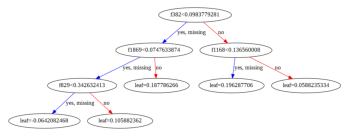

In [15]:
# plot decision tree
from xgboost import XGBClassifier

# fit model no training data
model = XGBClassifier()
model.fit(x_train_scaled, y_train)
# plot single tree

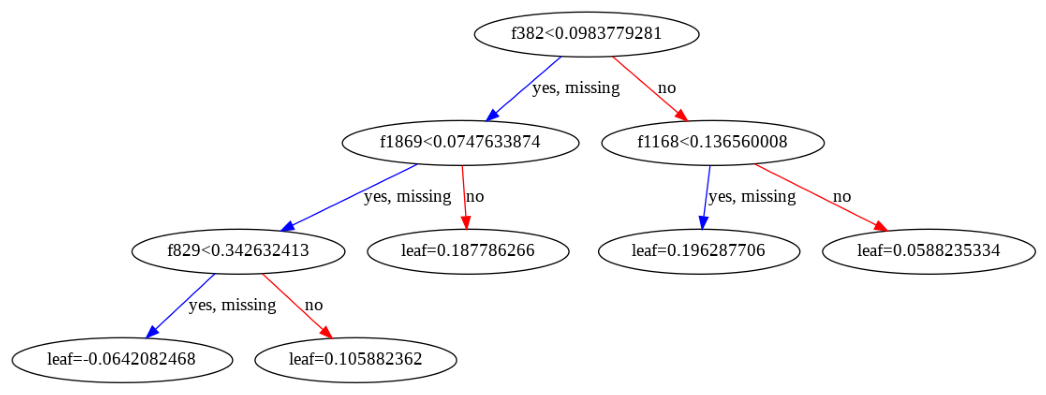

In [16]:
from xgboost import plot_tree
import matplotlib.pyplot as plt

%matplotlib inline

plot_tree(model)
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)
plt.show()

In [19]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import pandas as pd

# Se realizan las predicciones sobre el conjunto de validación
predictions = model.predict(x_test_scaled) 

# Calculo las métricas sobre test para el paper
acc_test = accuracy_score(y_test, predictions)
precision_test = precision_score(y_test, predictions, average='macro')
recall_test = recall_score(y_test, predictions, average='macro')
f1_test = f1_score(y_test, predictions, average='macro')

dict_test = {}
dict_test['clasificador'] = 'XGBoost'
dict_test['estrategia'] = 'TFIDF'
dict_test['accuracy'] = acc_test
dict_test['precision'] = precision_test
dict_test['recall'] = recall_test
dict_test['f1_score'] = f1_test
 
# Paso el diccionario a dataframe  
results_test = pd.DataFrame([dict_test])

# Los guardo
print(results_test)
print('Accuracy Test-Set: {}' . format(acc_test))

  clasificador estrategia  accuracy  precision    recall  f1_score
0      XGBoost      TFIDF     0.865   0.856724  0.835188  0.843465
Accuracy Test-Set: 0.865
